In [1]:
import os
import gc
from joblib import dump, load
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# load files

In [2]:
train = pd.read_parquet("../input/train_sma_magic_D_39.parquet")

# define loss and metric

In [3]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# define training config

In [21]:
features[-1]

'magic_D_39'

In [22]:
seed = 42
n_folds = 5

permutation_importances = load("permutation_importances.pkl")
permutation_importances = sorted(permutation_importances.items(), key=lambda x: x[1], reverse=False)

exclude_features = []
# exclude_features = [feature for (feature, score) in permutation_importances if score > 0.7922]

exclude_features += [
    "customer_ID", 
    "target",
    "number_of_observations",
    "magic_D_39"
]
features = [col for col in train.columns if col not in exclude_features]
target = "target"
cat_features_base = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
] 
cat_features = [
    "{}_last".format(feature) for feature in cat_features_base
]

xgb_parms = { 
    "max_depth":4, 
    "learning_rate":0.05, 
    "subsample":0.8,
    "colsample_bytree":0.6, 
    "eval_metric":"logloss",
    "objective":"binary:logistic",
    "tree_method":"gpu_hist",
    "gpu_id":1,
    "predictor":"gpu_predictor",
    "random_state":seed
}

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(seed)

In [23]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = pd.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [24]:
def training(train):

    importances = []
    
    # create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))

    kfold = StratifiedKFold(
        n_splits=n_folds, 
        shuffle=True, 
        random_state=seed
    )
    
    for fold,(trn_ind, val_ind) in enumerate(kfold.split(train, train[target])):

        print("#"*100)
        print("Training fold {} with {} features...".format(fold, len(features)))
        
        x_train= train.loc[trn_ind, features]
        y_train= train.loc[trn_ind, target]
        x_val = train.loc[val_ind, features]
        y_val = train.loc[val_ind, target]

        # xgb_train = xgb.DeviceQuantileDMatrix(xy_train, max_bin=256)
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_val = xgb.DMatrix(data=x_val, label=y_val)

        model = xgb.train(
            xgb_parms, 
            dtrain=xgb_train,
            evals=[(xgb_train,"train"),(xgb_val,"valid")],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100
        ) 
        model.save_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))

        # importance
        importance = model.get_score(importance_type="weight")
        importances.append(pd.DataFrame({"feature":importance.keys(), "importance_{}".format(fold):importance.values()}))

        # oof
        oof_preds = model.predict(xgb_val)
        score = amex_metric_mod(y_val.values, oof_preds)
        print("fold {} score is {}".format(fold, score))
        
        # add to out of folds array
        oof_predictions[val_ind] = oof_preds

        del x_train, y_train, x_val, y_val, xgb_train, xgb_val, model, importance, oof_preds
        _ = gc.collect()
    
    # compute oof
    score = amex_metric_mod(train[target], oof_predictions)
    print("oof score is {}".format(score))
    
    # create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({"customer_ID": train["customer_ID"], "target": train[target], "prediction": oof_predictions})
    oof_df.to_parquet("xgb_oof_{}.parquet".format(seed))
    
    return importances, oof_df

In [ ]:
importances, oof_df = training(train)

####################################################################################################
Training fold 0 with 1449 features...
[0]	train-logloss:0.66261	valid-logloss:0.66269
[100]	train-logloss:0.23622	valid-logloss:0.23924
[200]	train-logloss:0.22163	valid-logloss:0.22717
[300]	train-logloss:0.21551	valid-logloss:0.22347
[400]	train-logloss:0.21130	valid-logloss:0.22150
[500]	train-logloss:0.20797	valid-logloss:0.22034
[600]	train-logloss:0.20511	valid-logloss:0.21958
[700]	train-logloss:0.20247	valid-logloss:0.21911
[800]	train-logloss:0.20004	valid-logloss:0.21876
[900]	train-logloss:0.19779	valid-logloss:0.21847
[1000]	train-logloss:0.19559	valid-logloss:0.21828
[1100]	train-logloss:0.19350	valid-logloss:0.21814
[1200]	train-logloss:0.19150	valid-logloss:0.21800
[1300]	train-logloss:0.18953	valid-logloss:0.21787
[1400]	train-logloss:0.18754	valid-logloss:0.21775
[1500]	train-logloss:0.18565	valid-logloss:0.21768
[1586]	train-logloss:0.18406	valid-logloss:0.21768
fold 0

# feature importance

In [8]:
importance = importances[0].copy()
for k in range(1, n_folds): 
    importance = importance.merge(importances[k], on="feature", how="left")
    
importance["importance"] = importance.iloc[:,1:].mean(axis=1)
importance = importance.sort_values("importance",ascending=False)

importance.to_csv("xgb_feature_importance.csv",index=False)

In [10]:
magic_features = [col for col in importance.columns if "magic" in col]

In [11]:
importance[magic_features]

""
3
7
47
31
63
...
906
361
384
1178


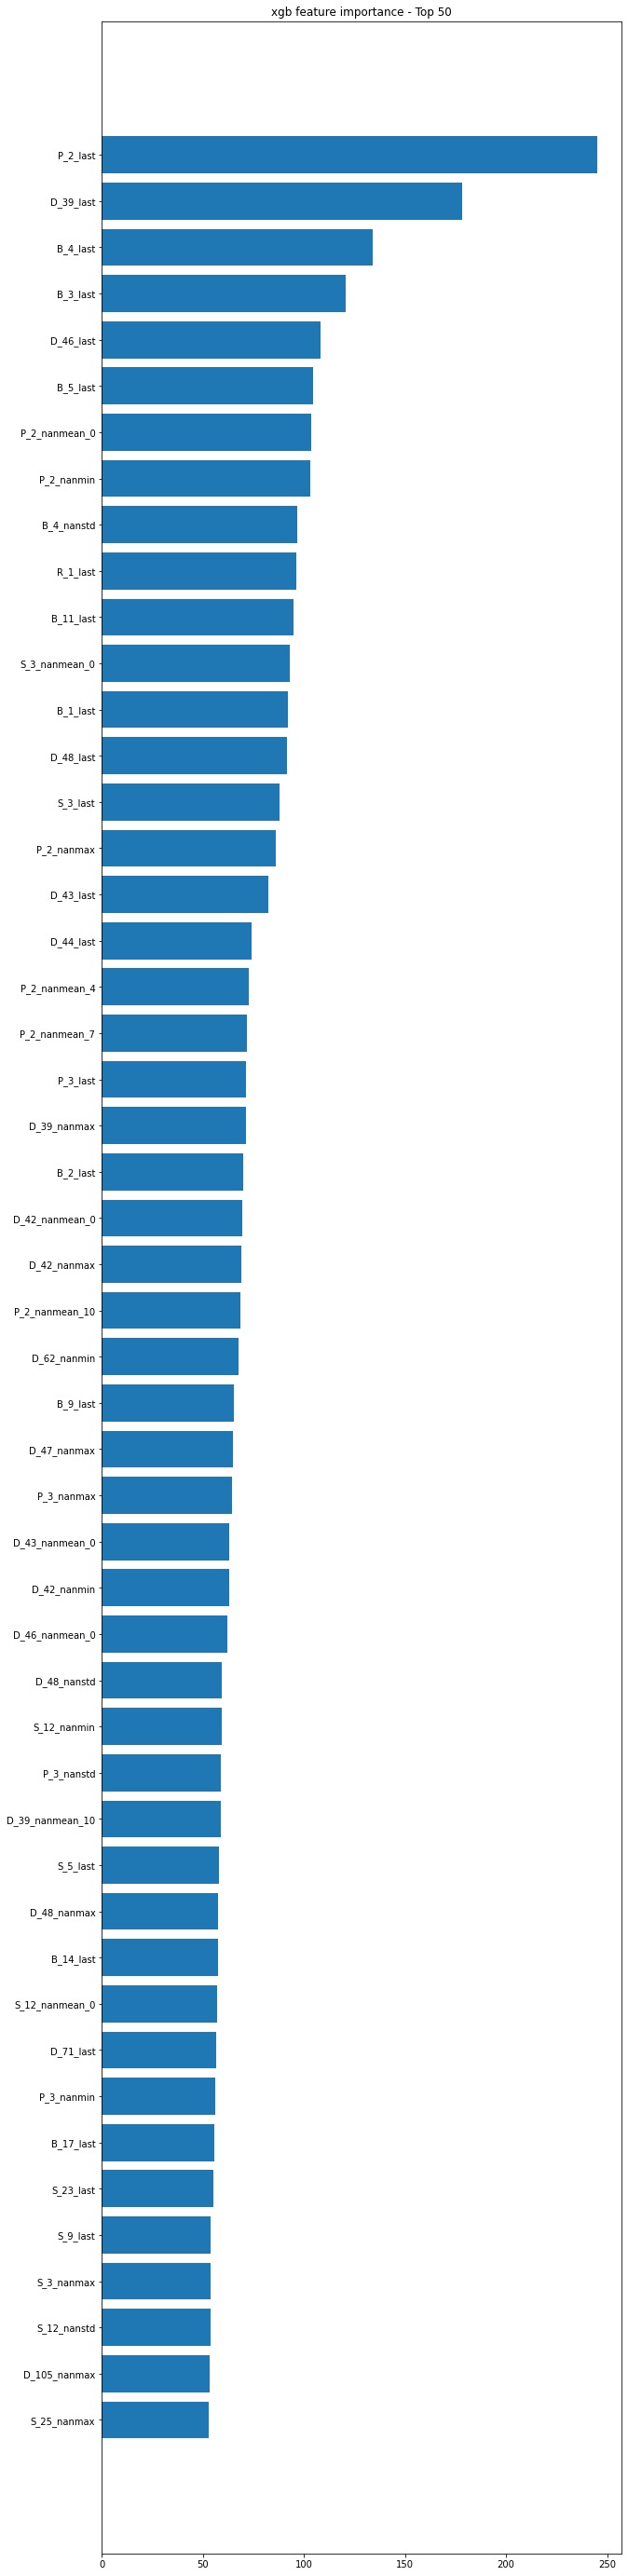

In [9]:
n_features = 50

plt.figure(figsize=(10, n_features))
plt.barh(np.arange(n_features, 0, -1), importance.importance.values[:n_features])
plt.yticks(np.arange(n_features,0,-1), importance.feature.values[:n_features])
plt.title("xgb feature importance - Top {}".format(n_features))
plt.show()

In [ ]:
importance

# Permutation Feature Importance

In [ ]:
def permutation(train, features):
    
    permutation_importances = {}
    
    for feature in tqdm(features):
        
        oof_predictions = np.zeros(len(train))
        
        kfold = StratifiedKFold(
            n_splits=n_folds, 
            shuffle=True, 
            random_state=seed
        )
    
        for fold,(trn_ind, val_ind) in enumerate(kfold.split(train, train[target])):

            x_val = train.loc[val_ind, features]
            x_val[feature] = np.random.RandomState(seed=42).permutation(x_val[feature])
            y_val = train.loc[val_ind, target]

            xgb_val = xgb.DMatrix(data=x_val, label=y_val)
            
            model = xgb.Booster()
            model.load_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))

            # oof
            oof_preds = model.predict(xgb_val)
            oof_predictions[val_ind] = oof_preds

            del x_val, y_val, xgb_val, model, oof_preds
            _ = gc.collect()

        # compute oof
        score = amex_metric_mod(train[target], oof_predictions)
        permutation_importances[feature] = score
    
        dump(permutation_importances, "permutation_importances.pkl")
    
    return permutation_importances

In [ ]:
permutation_importances = permutation(train, features)